In [1]:
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from ast import literal_eval

In [2]:
df = pd.read_csv("output/coded.csv")
df = df.loc[df["verb_display"]=="be+like"]
df["temp"] = df["temp"].apply(lambda s: literal_eval(s))

In [3]:
# Get the non-contracted forms of be
df["be_form"] = df["temp"].apply(
    lambda t:
    " ".join(t[:-1])
)

# For all instances of contracted copula, fill in the blanks accordingly
df.loc[df.subj_val.str.contains("I'm", case=False), ["be_form"]] = "am"
df.loc[df.subj_val.str.contains("we're", case=False), ["be_form"]] = "are"
df.loc[df.subj_val.str.contains("s?he's", case=False), ["be_form"]] = "is"

# Determine person category from the T/F columns
def get_person_category(row):
    if row['subj_1st']:
        return '1st person'
    elif row['subj_3rd']:
        return '3rd person'

df['person'] = df.apply(get_person_category, axis=1)

def get_num_category(row):
    if row['subj_SG']:
        return 'sing.'
    elif row['subj_PL']:
        return 'pl.'

df['number'] = df.apply(get_num_category, axis=1)

In [4]:
be_form_display = {
    'am': 'AM', 
    'was': 'WAS', 
    'be': 'BE',
    '': 'ZERO', 
    'is': 'IS/ARE', 
    'were': 'WERE', 
    'are': 'IS/ARE', 
    'had been': 'HAD BEEN', 
    'been': 'BEEN'
}

df["be_display"] = df.be_form.map(be_form_display)

In [5]:
morph_category = {
    'am': 'NON-PAST', 
    'was': 'PAST', 
    'be': 'NON-PAST',
    '': 'NON-PAST', 
    'is': 'NON-PAST', 
    'were': 'PAST', 
    'are': 'NON-PAST', 
    'had been': 'PAST', 
    'been': 'PAST'
}

df["be_morph"] = df["be_form"].map(morph_category)

In [12]:
# Count unique speakers per cohort
speaker_counts = df.groupby('cohort')['speaker_id'].nunique() 

# Get cohorts with at least 5 speakers
cohort_order = sorted(speaker_counts[speaker_counts >= 5].index.tolist())

# Filter your dataframe
df = df[df['cohort'].isin(cohort_order)]

# Distribution of *be* morphological forms
*as in Figure 9 (p. 627) of Cukor-Avila (2012). Ish.*

NB: I can't code for temporal reference due to resources so I can't really replicate Figure 9, instead we can:
 - map forms to display codes
 - group them as past or non-past morphology
 - group bars for cohorts


Percentage of morphology within each cohort:
be_morph             NON-PAST   PAST
cohort                              
Cohort 1\n1941-60       54.43  45.57
Cohort 2\n1961-77       35.80  64.20
Cohort 3\n1978-90       39.18  60.82
Cohort 4\n1991-2002     52.52  47.48


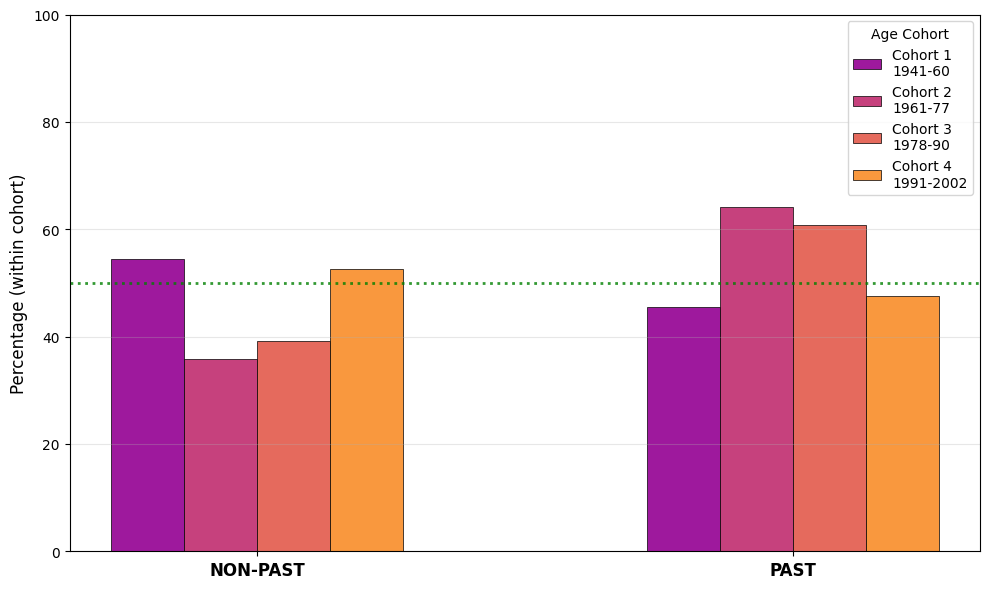

In [13]:
cohort_order = [
    "Before 1941",
    "Cohort 1\n1941-60", 
    "Cohort 2\n1961-77", 
    "Cohort 3\n1978-90", 
    "Cohort 4\n1991-2002",
    "After 2002"
]

group_order = [
    '9-12',
    '13-16', 
    '17-29', 
    '30-39', 
    '40-49', 
    '50-59', 
    '60+'
]

# Calculate percentages within each cohort
cohort_morph_pct = pd.crosstab(
    df_cohorts['cohort'],
    df_cohorts['be_morph'],
    normalize='index'  # Percentages within each cohort (rows sum to 100%)
) * 100

# Order columns
category_order = ['NON-PAST', 'PAST']
cohort_morph_pct = cohort_morph_pct[category_order]

# Bar settings
n_cohorts = len(cohort_order)
n_categories = len(category_order)
bar_width = 0.15
group_width = bar_width * n_cohorts
group_gap = 0.2

# Colors for each cohort
cohort_colors = plt.cm.plasma(np.linspace(0.2, 0.9, n_cohorts))

# X positions for each morphology category
x_categories = np.arange(n_categories) * (group_width + group_gap)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
# Plot bars
for i, cohort in enumerate(cohort_order):
    if cohort in cohort_morph_pct.index:
        heights = cohort_morph_pct.loc[cohort, category_order].values
        x_positions = x_categories + i * bar_width
        ax.bar(x_positions, heights, bar_width,
               label=cohort, color=cohort_colors[i],
               edgecolor='black', linewidth=0.5)

# Set x-axis labels at center of each group
ax.set_xticks(x_categories + group_width / 2 - bar_width / 2)
ax.set_xticklabels(category_order, fontsize=12, fontweight='bold')

# Dotted line to show 50% mark
ax.axhline(y=50, color='green', linestyle=':', linewidth=2, alpha=0.8)
# Formatting
ax.set_ylabel('Percentage (within cohort)', fontsize=12)
ax.set_ylim(0, 100)
ax.legend(title='Age Cohort', loc='upper right', fontsize=10, frameon=True)
ax.grid(axis='y', alpha=0.3, zorder=0)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig("viz/age_cohort_non_vs_past_morph.png")
# Print summary
print("\nPercentage of morphology within each cohort:")
print(cohort_morph_pct.round(2))

# Distribution of non-past *be* in *be like* quotatives
* as in Figure 10 (p. 629) of Cukor-Avila (2012)*

Stack bars for subject person value with a non-past form, for the last 4 cohorts, who appear to have stabilized in usage.

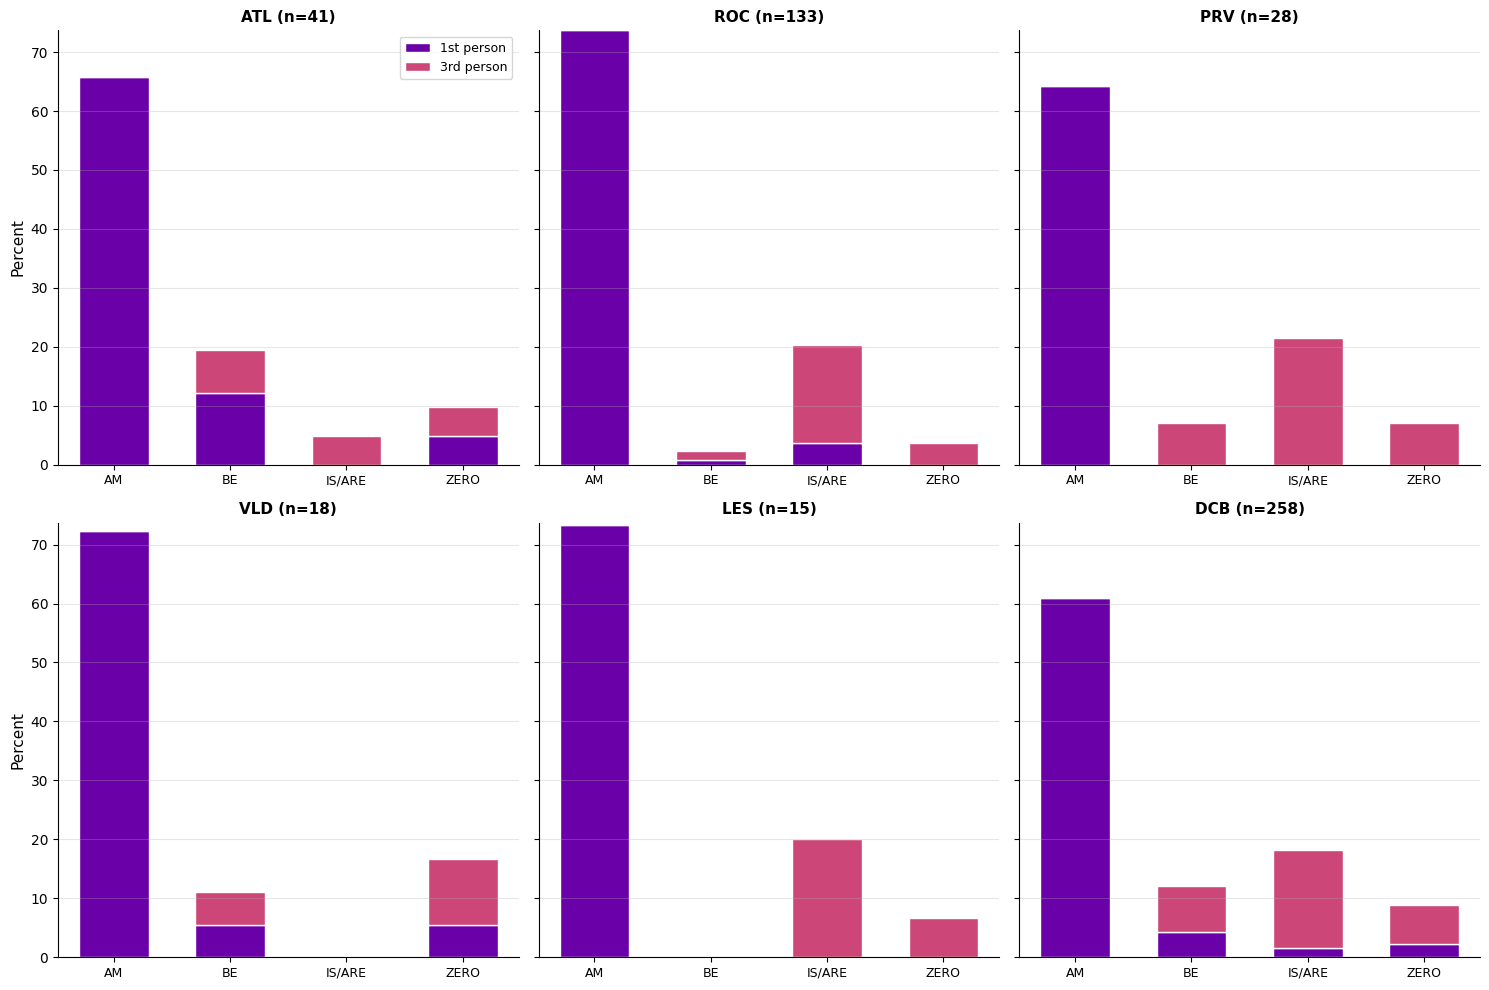

In [14]:
cohort_order = [
    "Cohort 3\n1978-90",
    "Cohort 4\n1991-2002"
]
person_order = ['1st person', '3rd person']
nonpast_df = df.loc[df.be_morph == "NON-PAST"]
nonpast_df = nonpast_df.loc[nonpast_df.cohort.isin(cohort_order)]

be_form_order = sorted(nonpast_df.be_display.unique())
regions = nonpast_df['region_id'].unique()

# Create subplots - one per region
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

person_colors = plt.cm.plasma(np.linspace(0.2, 0.5, len(person_order)))

for idx, region in enumerate(regions):
    ax = axes[idx]
    region_data = nonpast_df[nonpast_df['region_id'] == region]
    
    # Skip if no data
    if len(region_data) == 0:
        ax.axis('off')
        continue
    
    # Create contingency table for this region
    contingency = pd.crosstab(
        region_data['be_display'], 
        region_data['person'],
        normalize='all'
    ) * 100
    
    contingency = contingency.reindex(be_form_order, fill_value=0)
    
    # Plot stacked bars
    x = np.arange(len(be_form_order))
    bar_width = 0.6
    bottom = np.zeros(len(be_form_order))
    
    for i, person in enumerate(person_order):
        if person in contingency.columns:
            heights = contingency[person].values
            ax.bar(x, heights, bar_width, bottom=bottom,
                   label=person if idx == 0 else "",
                   color=person_colors[i],
                   edgecolor='white', linewidth=1)
            bottom += heights
    
    ax.set_title(f'{region} (n={len(region_data)})', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(be_form_order, fontsize=9)
    ax.grid(axis='y', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if idx % 3 == 0:
        ax.set_ylabel('Percent', fontsize=11)

# Hide extra subplot
if len(regions) < 6:
    axes[-1].axis('off')

# Add legend to first subplot
axes[0].legend(loc='upper right', fontsize=9, frameon=True)

# plt.suptitle('Non-past "be" forms by region and person\n(Cohorts 4 & After 2002)', 
             # fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
# plt.savefig("viz/old_cohorts_nonpast_morph_by_region_per.png")

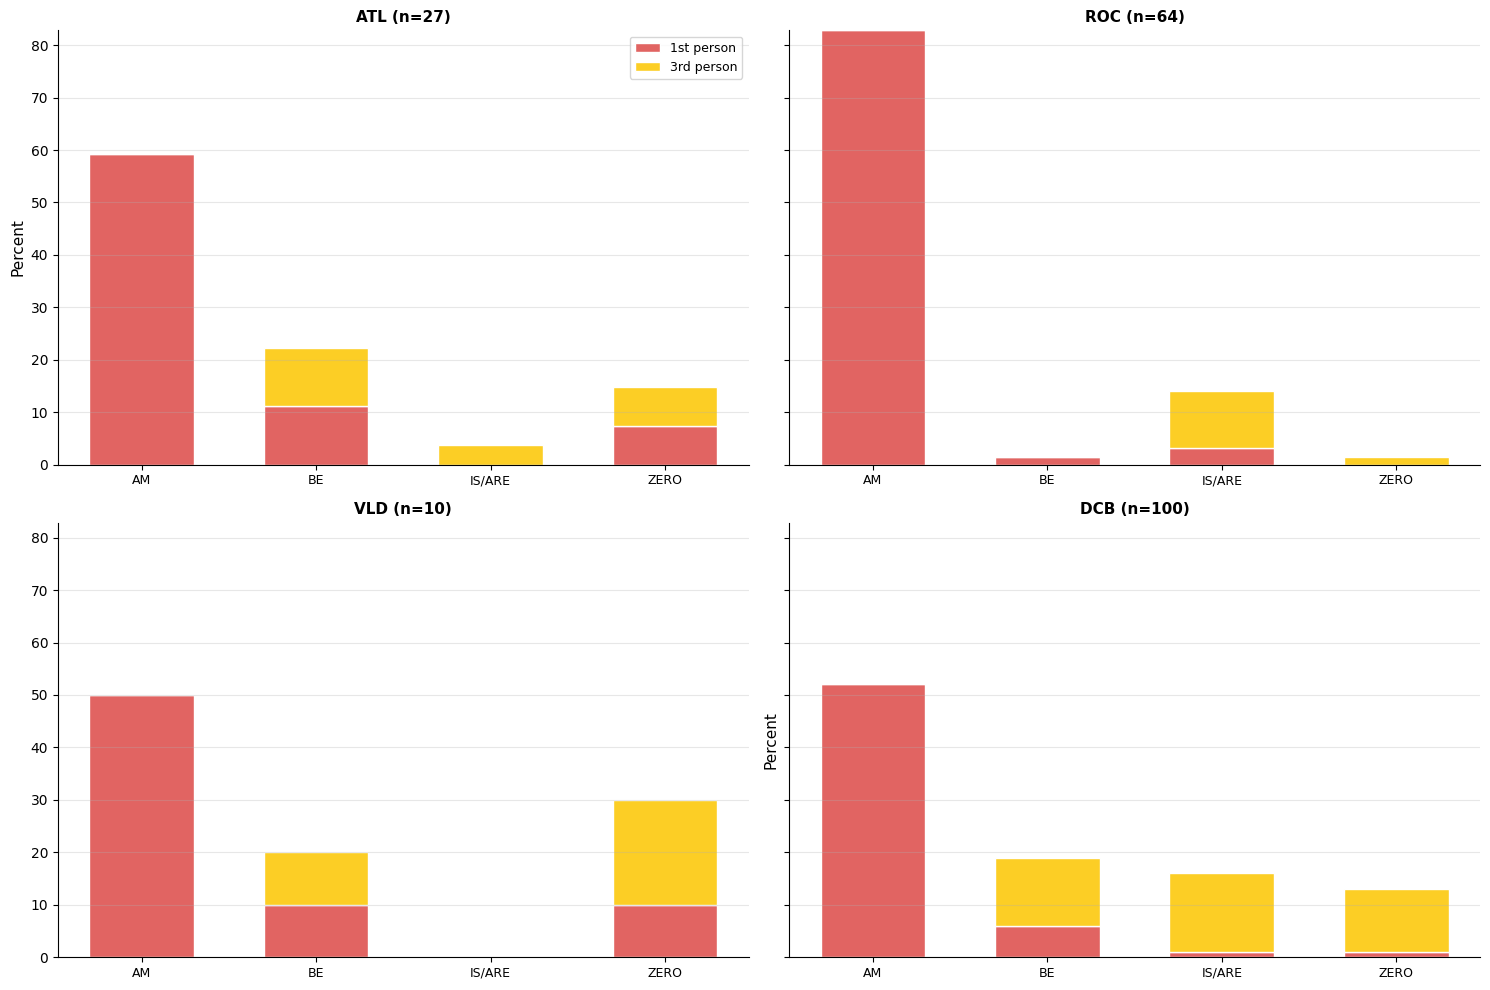

In [57]:
cohort_order = [
    "Cohort 4\n1991-2002",
    "After 2002"
]

person_order = ['1st person', '3rd person']
nonpast_df = df.loc[df.be_morph == "NON-PAST"]
nonpast_df = nonpast_df.loc[nonpast_df.cohort.isin(cohort_order)]

be_form_order = sorted(nonpast_df.be_display.unique())
regions = nonpast_df['region_id'].unique()

# Create subplots - one per region
n_regions = len(regions)
n_facets = n_regions // 2 + n_regions % 2
fig, axes = plt.subplots(2, n_facets, figsize=(15, 10), sharey=True)
axes = axes.flatten()

person_colors = plt.cm.plasma(np.linspace(0.6, 0.9, len(person_order)))

for idx, region in enumerate(regions):
    ax = axes[idx]
    region_data = nonpast_df[nonpast_df['region_id'] == region]
    
    # Skip if no data
    if len(region_data) == 0:
        ax.axis('off')
        continue
    
    # Create contingency table for this region
    contingency = pd.crosstab(
        region_data['be_display'], 
        region_data['person'],
        normalize='all'
    ) * 100
    
    contingency = contingency.reindex(be_form_order, fill_value=0)
    
    # Plot stacked bars
    x = np.arange(len(be_form_order))
    bar_width = 0.6
    bottom = np.zeros(len(be_form_order))
    
    for i, person in enumerate(person_order):
        if person in contingency.columns:
            heights = contingency[person].values
            ax.bar(x, heights, bar_width, bottom=bottom,
                   label=person if idx == 0 else "",
                   color=person_colors[i],
                   edgecolor='white', linewidth=1)
            bottom += heights
    
    ax.set_title(f'{region} (n={len(region_data)})', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(be_form_order, fontsize=9)
    ax.grid(axis='y', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if idx % 3 == 0:
        ax.set_ylabel('Percent', fontsize=11)

# Hide extra subplots
if n_regions < n_facets:
    axes[-1].axis('off')

# Add legend to first subplot
axes[0].legend(loc='upper right', fontsize=9, frameon=True)

# plt.suptitle('Non-past "be" forms by region and person\n(Cohorts 4 & After 2002)', 
             # fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
# plt.show()
plt.savefig("viz/young_cohorts_nonpast_morph_by_region_per.png")